# Partie 0 : Quelques imports de bon fonctionnement

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import random as rd

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [ ]:
import csv

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
def convert_to_one_hot(vecteur):
    n_values = int(np.max(vecteur) + 1)
    oh = np.eye(n_values)[vecteur]
    return oh

In [ ]:
data = pd.read_csv("/content/drive/My Drive/Wine_project/winemag-data-130k-v2.csv")

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/My Drive/Wine_project/glove.6B.50d.txt')

# Partie 1: Statistiques descriptives

In [ ]:
data = data.drop('Unnamed: 0', axis = 1)
data.columns


Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')

In [ ]:
data['country'].nunique()
data['region_2'].nunique()
data['province'].count()

129908

In [ ]:
data.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [ ]:
data.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

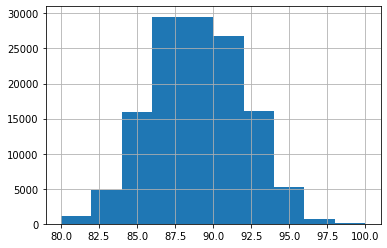

In [ ]:
fig = data['points'].hist()
plt.show()

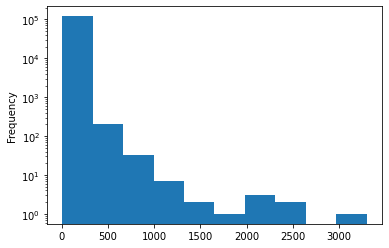

In [ ]:
fig = data['price'].plot(kind = 'hist', logy=True)
plt.show()

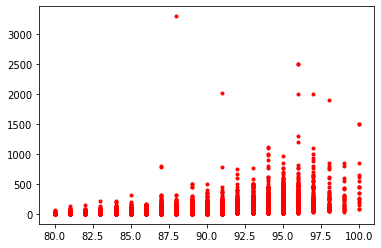

In [ ]:
plt.plot(data['points'], data['price'], 'r.')

In [ ]:
priceForPoint = data.groupby(by="points").mean()

In [ ]:
#PriceForPoint donne la moyenne du prix de la bouteille pour un nbr de point donné

[]

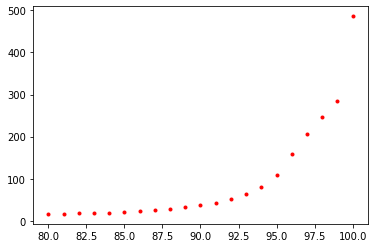

In [ ]:
plt.plot(priceForPoint.index, priceForPoint , 'r.')
plt.plot()

[]

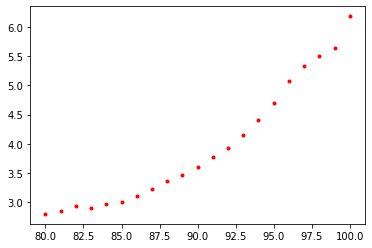

In [ ]:
plt.plot(priceForPoint.index, np.log(priceForPoint) , 'r.')
plt.plot()

In [ ]:
countries = data[ ["country", "winery"] ].groupby(by="country").count().sort_values(by="winery")[::-1]
countries.count()

winery    43
dtype: int64

In [ ]:
countries_price = data[ ["country", "price"]].groupby(by ="country").mean()

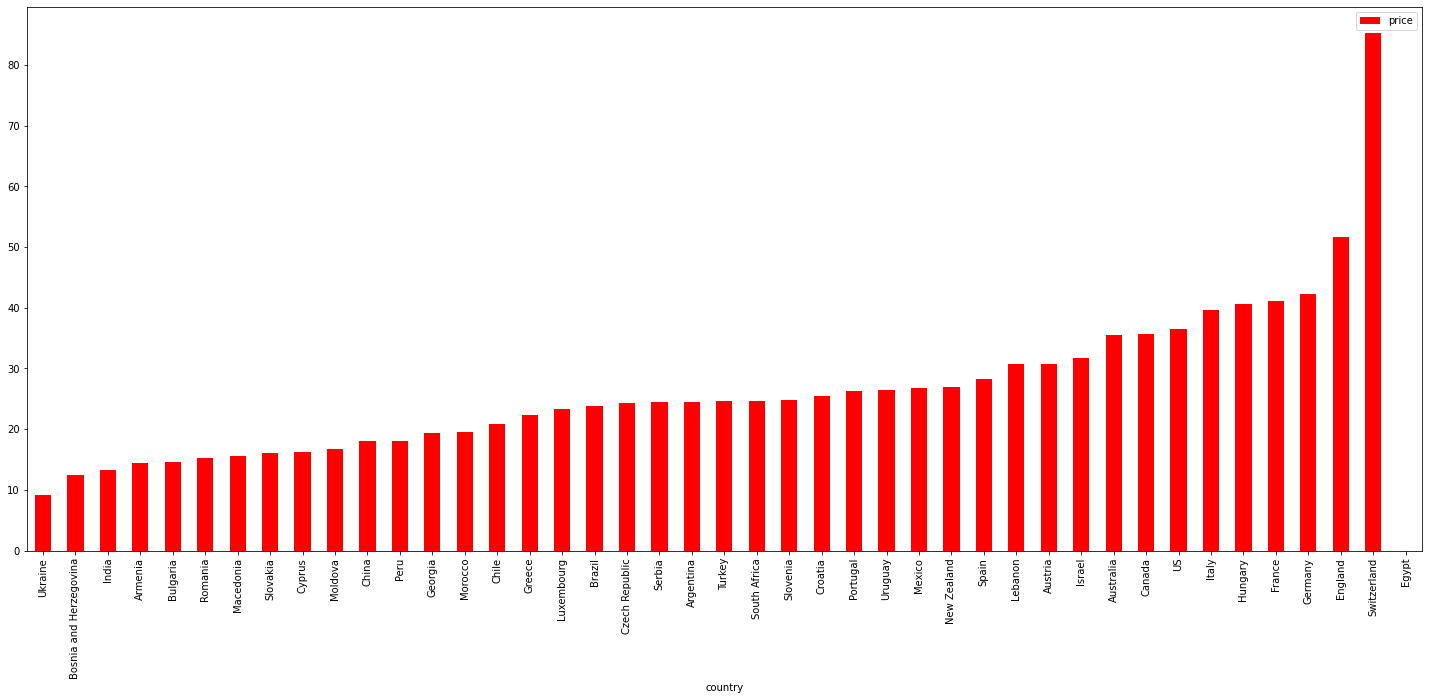

In [ ]:
countries_price.sort_values('price').plot(kind = "bar", figsize = (25,10), color = 'red')

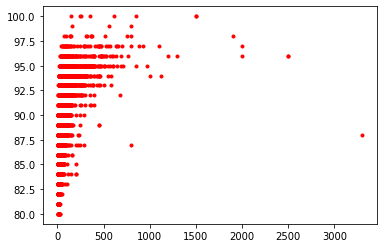

In [ ]:
dfr=data[data["country"] == 'France']
plt.plot(dfr['price'],dfr['points'], 'r.')

In [ ]:
dfr_max=dfr[dfr['price']> dfr['price'].quantile( q = 0.99)]

In [ ]:
dfr_max=dfr_max[['region_1','winery']]

In [ ]:
dfr_max.count()

region_1    172
winery      172
dtype: int64

In [ ]:
dfr_max_winery = dfr_max.groupby('region_1').count().sort_values(by="winery")[::-1]
dfr_max_winery.head()

,winery
region_1,
Champagne,22
Pessac-Léognan,13
Pauillac,12
Chevalier-Montrachet,11
Bâtard-Montrachet,10


# Partie 2 : Premier Modèle

## Modèle 1.1

In [41]:
data_10000 = data.sample(frac = 0.1, random_state = 1)
X = data_10000['description']
Y = data_10000['points']

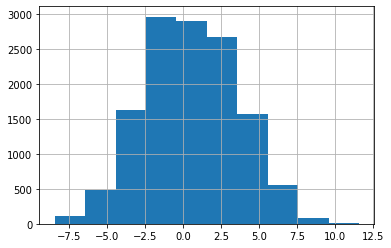

In [42]:
Y_corr= Y-Y.mean()
fig = Y_corr.hist()
plt.show()

In [43]:
#On va essayer de prédire, en fonction de la description, un score en séparant en 5 parties qui sera ensuite ramené sur 100.

In [44]:
groupe = (max(Y_corr)-min(Y_corr))/5
print("on va faire 5 catégories de taille", groupe+0.001)

on va faire 5 catégories de taille 4.001


In [45]:
Y_corr = np.array(Y_corr)
X = np.array(X)
mini = min(Y_corr)
for idx in range(len(Y_corr)):
    Y_corr[idx] = abs(Y_corr[idx] - mini)//4.001   

In [46]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y_corr,test_size=0.2)
Y_train = np.array(Y_train, dtype = int)

In [47]:
def sentence_to_avg(sentence, word_to_vec_map):
 
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(50)
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    total = 0
    for w in words:
        while w not in word_to_vec_map.keys():
            if w[1:] in word_to_vec_map.keys():
                w = w[1:]
            else:
                w = w[:-1]
        total += word_to_vec_map[w]
    avg = total/len(words)
    
    
    return avg

In [48]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):

    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,)) 
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W,avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = - np.dot(Y_oh[i],np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [49]:
def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                       # Loop over training examples
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # Average words' vectors
        avg = np.zeros((50,))
        for w in words:
            while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
            avg += word_to_vec_map[w]
        avg = avg/len(words)

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

In [50]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 0.6965057893850656
Accuracy: 0.5036068096566317
Epoch: 100 --- cost = 0.8432572403147153
Accuracy: 0.5469847071270559
Epoch: 200 --- cost = 0.8192252549777557
Accuracy: 0.5474656150812734
Epoch: 300 --- cost = 0.8132783010461534
Accuracy: 0.5467923439453689
[[1.]
 [1.]
 [2.]
 ...
 [2.]
 [2.]
 [1.]]


In [51]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.5470808887178994
Test set:
Accuracy: 0.541923076923077


In [52]:
#On se retrouve avec une accuracy de 50... ce qui est mieux que le hasard (5 catégories) mais pas encore optimal
#On va utiliser un algo de LTSM pour pouvoir cette fois ci prendre en compte l'ordre des éléments dans la phrase

In [53]:
#Quelques test
idx = rd.randint(0,len(X))
X[idx],Y_corr[idx], idx

('One year of wood aging has given this wine its toasty character. It is balanced with the red-cherry fruit and acidity. Named after the constable who controlled the castle of Sancerre in the Middle Ages, the wine is dense with tannins as well as the fruit. It should be ready to drink, although it does seem on the dry side.',
 2.0,
 831)

In [54]:
X_my_sentences = np.array(["I love that wine, it is so tasteful. A great success to see in the future"])
Y_my_labels = np.array([[3]])
pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
pred

Accuracy: 1.0


array([[3.]])

In [55]:
X_my_sentences = np.array(["I love that wine , it is so tasteful. A great success ! Tasteful love so good"])
Y_my_labels = np.array([[4]])
pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
pred

Accuracy: 0.0


array([[3.]])

In [56]:
#Regardons à partir d'une matrice de confusion ce qui pose problème

In [65]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

Predicted  0.0  1.0  3.0  4.0   All
Actual                             
0          411  169   38   65   683
1          233  235   93  133   694
2           66   87   38   56   247
3           78  127  107  222   534
4           31   80   66  265   442
All        819  698  342  741  2600


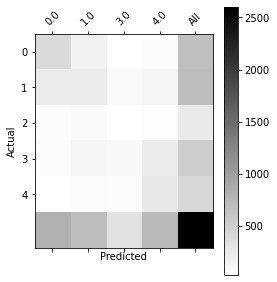

In [66]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

In [59]:
#Problème : pas assez de '4' pour que l'algo le prédise..., les classes sont trop centrées sur 3 et 4. Il nous faut une refonte des groupes.

## Modèle 1.2

In [60]:
quant = Y.quantile([0.2,0.4,0.6,0.8,1])

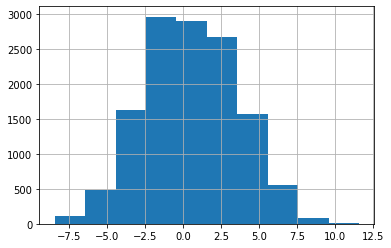

In [61]:
data_1000 = data.sample(frac = 0.1, random_state = 1)
X = data_1000['description']
Y = data_1000['points']

Y_corr= Y-Y.mean()
quant = quant - Y.mean()
fig = Y_corr.hist()
plt.show()

Y_corr = np.array(Y_corr)
for idx in range(len(Y_corr)):
    if Y_corr[idx] <= quant[0.2]:
        Y_corr[idx] = 0
    elif Y_corr[idx] <= quant[0.4]:
        Y_corr[idx] = 1
    elif Y_corr[idx] <= quant[0.6]:
        Y_corr[idx] = 2
    elif Y_corr[idx] <= quant[0.8]:
        Y_corr[idx] = 3
    else:
        Y_corr[idx] = 4

In [62]:
X = np.array(X)
Y_corr = np.array(Y_corr, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y_corr,test_size=0.2)


In [63]:
pred, W_1, b_1 = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.5891297096141028
Accuracy: 0.35365970953159565
Epoch: 100 --- cost = 0.8134250211343161
Accuracy: 0.4206982783495239
Epoch: 200 --- cost = 0.8219942669290246
Accuracy: 0.42175627584880254
Epoch: 300 --- cost = 0.8288120869847141
Accuracy: 0.421275367894585
[[0.]
 [3.]
 [1.]
 ...
 [0.]
 [0.]
 [4.]]


In [64]:
print("Training set:")
pred_train = predict(X_train, Y_train, W_1, b_1, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W_1, b_1, word_to_vec_map)


Training set:
Accuracy: 0.42252572857555065
Test set:
Accuracy: 0.39153846153846156


Predicted  0.0  1.0  3.0  4.0   All
Actual                             
0          411  169   38   65   683
1          233  235   93  133   694
2           66   87   38   56   247
3           78  127  107  222   534
4           31   80   66  265   442
All        819  698  342  741  2600


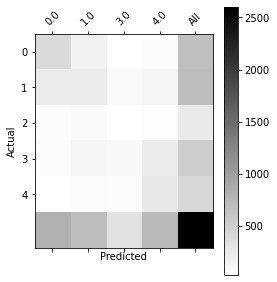

In [67]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

In [ ]:
#Mieux que le hasard certes mais toujours pas fou, on va tenter le LSTM

# Partie 3 : Modèle LSTM

In [222]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

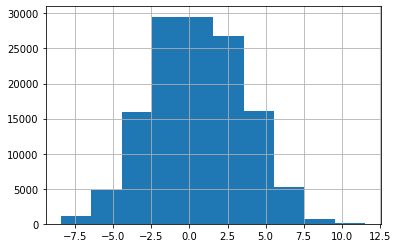

In [223]:
data_10000 = data.sample(frac = 1, random_state = 1)
data_10000 = data_10000.sort_values(by=['points'])
X_LTSM = data_10000['description']
Y = data_10000['points']
Y_corr= (Y-Y.mean())
quant = Y.quantile([0.2,0.4,0.6,0.8,1])
quant = quant - Y.mean()
fig = Y_corr.hist()
plt.show()

X_LTSM = np.array(X_LTSM)
Y_corr = np.array(Y_corr)

maxLen = 0
#erase = []
for i in range(len(X_LTSM)):
    po = 0
    
    if maxLen < len(X_LTSM[i].split()) and po == 0:
      maxLen = len(X_LTSM[i].split())
#np.delete(X_LTSM, erase)
#np.delete(Y_corr, erase)

for idx in range(len(Y_corr)):
    if Y_corr[idx] <= quant[0.2] and np.sum(Y_corr ==0) < len(Y_corr)/5:
        Y_corr[idx] = 0
    elif Y_corr[idx] <= quant[0.4] and np.sum(Y_corr == 1) < len(Y_corr)/5:
        Y_corr[idx] = 1
    elif Y_corr[idx] <= quant[0.6] and np.sum(Y_corr == 2) < len(Y_corr)/5:
        Y_corr[idx] = 2
    elif Y_corr[idx] <= quant[0.8] and np.sum(Y_corr == 3) < len(Y_corr)/5:
        Y_corr[idx] = 3
    else:
        Y_corr[idx] = 4


In [224]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
          while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
            # Set the (i,j)th entry of X_indices to the index of the correct word.
          X_indices[i, j] = word_to_index[w]
          j += 1
            
    
    return X_indices

In [225]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = True)
    ### END CODE HERE ###

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [226]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


In [227]:
def Wine_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(input_shape, dtype= 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense( units = 5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [228]:
model = Wine_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 135)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 135, 50)           20000000  
_________________________________________________________________
lstm_10 (LSTM)               (None, 135, 128)          91648     
_________________________________________________________________
dropout_10 (Dropout)         (None, 135, 128)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)               

In [229]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [230]:
Y_corr = np.array(Y_corr, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X_LTSM,Y_corr,test_size=0.2)

In [231]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train)

In [1]:
model.fit(X_train_indices, Y_train_oh, epochs = 10, batch_size = 1500, shuffle=True)

NameError: ignored

In [233]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

813/813 [==============================] - 66s 81ms/step - loss: 1.0890 - accuracy: 0.5146

Test accuracy =  0.5145989656448364


 # Partie 4: Le retour du modèle 1

In [118]:
def sentence_to_avg(sentence, word_to_vec_map):
 
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(50)
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    total = 0
    for w in words:
        while w not in word_to_vec_map.keys():
            if w[1:] in word_to_vec_map.keys():
                w = w[1:]
            else:
                w = w[:-1]
        total += word_to_vec_map[w]
    avg = total/len(words)
    
    
    return avg

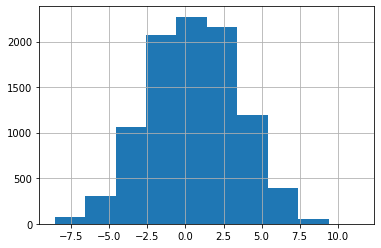

In [119]:
data_1000 = data[['description', 'points', 'price', 'taster_name']].sample(frac = 0.1, random_state = 1)
data_1000 = data_1000.dropna()
X = data_1000['description']
Y = data_1000['points']
prices = data_1000['price']
quant = Y.quantile([0.2,0.4,0.6,0.8,1])
Y_corr= Y-Y.mean()
quant = quant - Y.mean()
fig = Y_corr.hist()
plt.show()

Y_corr = np.array(Y_corr)
for idx in range(len(Y_corr)):
    if Y_corr[idx] <= quant[0.2]:
        Y_corr[idx] = 0
    elif Y_corr[idx] <= quant[0.4]:
        Y_corr[idx] = 1
    elif Y_corr[idx] <= quant[0.6]:
        Y_corr[idx] = 2
    elif Y_corr[idx] <= quant[0.8]:
        Y_corr[idx] = 3
    else:
        Y_corr[idx] = 4

m=len(X)

X = np.array(X)
X_emb = np.zeros((m,50)) 
prices = np.array(prices)
prices = np.log(prices)
prices = prices - prices.mean()
taster = testeur(data_1000)/18
for i in range(m): 
  X_emb[i] = sentence_to_avg(X[i], word_to_vec_map)
X_emb = np.column_stack((X_emb,prices))
X_emb = np.column_stack((X_emb,taster))
Y_corr = np.array(Y_corr, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X_emb,Y_corr,test_size=0.2)

In [120]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [121]:
def model_4(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 800):

    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 52                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,)) 
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
          
            # Forward propagate the avg through the softmax layer
            z = np.dot(W,X[i]) + b
            a = softmax(z)
            
            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = - np.dot(Y_oh[i],np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), X[i].reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict_4(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [122]:
def predict_4(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                       # Loop over training examples
        
        # Forward propagation
        Z = np.dot(W, X[j]) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

In [123]:
pred, W_4, b_4 = model_4(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.6421009536703286
Accuracy: 0.4024501498761892
Epoch: 100 --- cost = 1.2643346965880846
Accuracy: 0.46513749511273295
Epoch: 200 --- cost = 1.2287512307246695
Accuracy: 0.46565880359702855
Epoch: 300 --- cost = 1.21907467316436
Accuracy: 0.46552847647595463
Epoch: 400 --- cost = 1.2138647860723726
Accuracy: 0.46604978496025024
Epoch: 500 --- cost = 1.2100777407520482
Accuracy: 0.46578913071810246
Epoch: 600 --- cost = 1.2070651488438175
Accuracy: 0.46565880359702855
Epoch: 700 --- cost = 1.2046114545360052
Accuracy: 0.4653981493548808
[[4.]
 [0.]
 [0.]
 ...
 [4.]
 [1.]
 [3.]]


In [124]:
print("Training set:")
pred_train = predict_4(X_train, Y_train, W_4, b_4, word_to_vec_map)
print('Test set:')
pred_test = predict_4(X_test, Y_test, W_4, b_4, word_to_vec_map)

Training set:
Accuracy: 0.46565880359702855
Test set:
Accuracy: 0.48514851485148514


Predicted  0.0  1.0  2.0  3.0  4.0   All
Actual                                  
0          381   80    1   40    2   504
1          170  175    3  125   12   485
2           49   58    3   67   10   187
3           35   98    3  231   47   414
4            4   28    0  156  141   329
All        639  439   10  619  212  1919


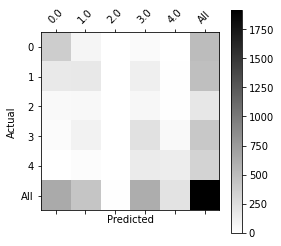

In [125]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

In [90]:
def testeur(data):
  taster = data['taster_name'].astype('category').values
  value_taster = []
  compteur = 0
  d = {}
  for i in range(len(taster)):
    if taster[i] not in d.keys():
      d[taster[i]] = compteur
      compteur += 1
    value_taster.append(d[taster[i]])
  return np.array(value_taster)